In [1]:
# To import util functions
import os
import sys
module_path = os.path.abspath(os.path.join('../util'))
if module_path not in sys.path:
    sys.path.append(module_path)

import datasetManager_FF as dM
import cleaner_FF as cl

In [2]:
#Common libraries for work with data
import pandas as pd
import numpy as np
from sklearn import preprocessing

#Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Model libraries
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Model training libraries
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

#Other
import pickle

/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# Cargo el dataset
df = dM.cargar_datos(0.1)

In [4]:
# Informacion de las variables
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548945 entries, 0 to 548944
Data columns (total 102 columns):
BuyCard_sum_dsi0                    548945 non-null int64
BuyCard_sum_dsi1                    548945 non-null int64
BuyCard_sum_dsi2                    548945 non-null int64
BuyCard_sum_dsi3                    548945 non-null int64
ChangeArena_sum_dsi0                548945 non-null int64
ChangeArena_sum_dsi1                548945 non-null int64
ChangeArena_sum_dsi2                548945 non-null int64
ChangeArena_sum_dsi3                444608 non-null float64
EnterDeck_sum_dsi0                  548945 non-null int64
EnterDeck_sum_dsi1                  548945 non-null int64
EnterDeck_sum_dsi2                  548945 non-null int64
EnterDeck_sum_dsi3                  548945 non-null int64
EnterShop_sum_dsi0                  548945 non-null int64
EnterShop_sum_dsi1                  548945 non-null int64
EnterShop_sum_dsi2                  548945 non-null int64
EnterShop_sum_ds

<h2>Tratamiento de valores nulos</h2>

In [4]:
# Analisamos los datos por tipo. Esto nos va a ayudar a saber que tipos de modelos podemos trabajar
lista_columnas_bool = list(df.select_dtypes(include='bool').columns)
lista_columnas_object = list(df.select_dtypes(include='object').columns)
lista_columnas_num = list(df.select_dtypes(include=['int64','float64']).columns)

<h3>Tratamiento de valores nulos - Categoricas </h3>

In [6]:
lista_columnas_object

['categorical_1',
 'categorical_2',
 'categorical_3',
 'categorical_4',
 'categorical_5',
 'categorical_6',
 'categorical_7',
 'country',
 'device_model',
 'platform',
 'site',
 'user_id']

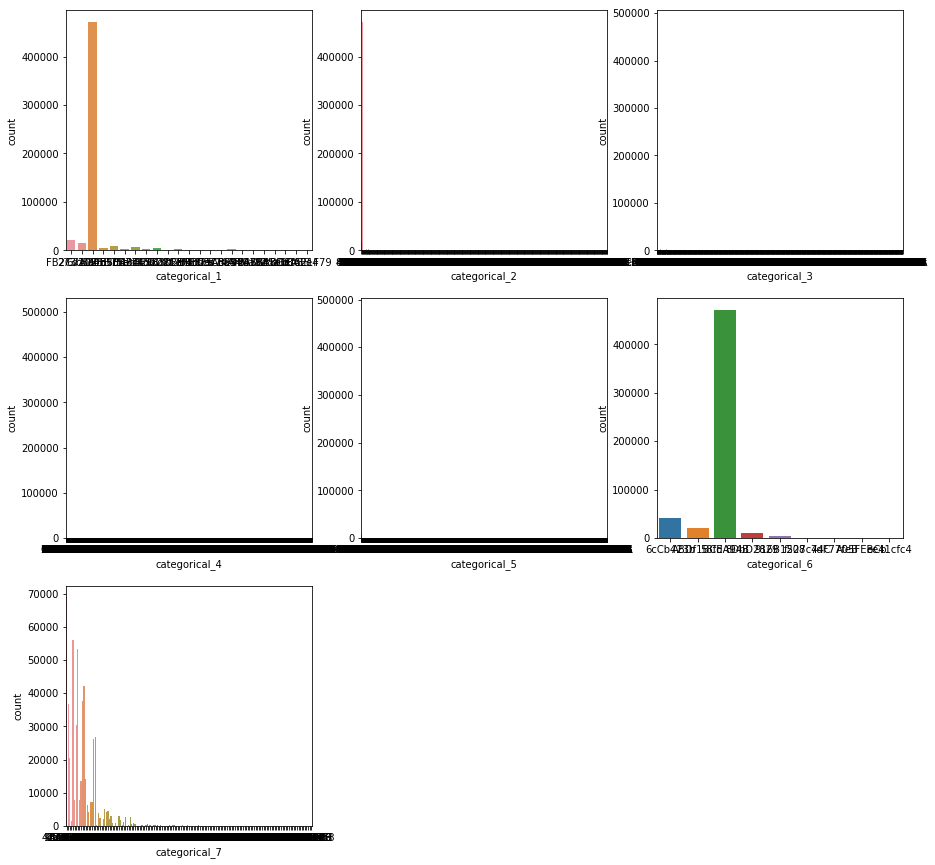

In [7]:
# plot de las variables categorical_x
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.catplot(x="categorical_1", kind="count", ax=axes[0, 0], data=df)
sns.catplot(x="categorical_2", kind="count", ax=axes[0, 1], data=df)
sns.catplot(x="categorical_3", kind="count", ax=axes[0, 2], data=df)
sns.catplot(x="categorical_4", kind="count", ax=axes[1, 0], data=df)
sns.catplot(x="categorical_5", kind="count", ax=axes[1, 1], data=df)
sns.catplot(x="categorical_6", kind="count", ax=axes[1, 2], data=df)
sns.catplot(x="categorical_7", kind="count", ax=axes[2, 0], data=df)

f.delaxes(axes[2][1])
f.delaxes(axes[2][2])

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)
plt.close(7)
plt.close(8)

5 Etiquetas principales

categorical_1
             Todos   Label 0   Label 1
67AD0B6E  0.858977  0.853247  0.883776
FB2Cd102  0.037421  0.037632  0.036506
273c8eEb  0.027138  0.027305  0.026411
64b5BA0D  0.015251  0.016911  0.008066
71ac826C  0.013987  0.015063  0.009328
Cantidad de etiquetas distintas: 23

categorical_2
             Todos   Label 0   Label 1
d7172d3e  0.858977  0.853247  0.883776
408BCCd9  0.030500  0.030759  0.029381
8CDd2dbD  0.013584  0.013653  0.013288
cbbffD0A  0.008178  0.008024  0.008843
A82d2dD5  0.003940  0.004176  0.002922
Cantidad de etiquetas distintas: 524

categorical_3
             Todos   Label 0   Label 1
aB5FcAd5  0.876803  0.872313  0.896239
A2bEfD7e  0.025995  0.026065  0.025693
504E175c  0.005800  0.005624  0.006562
BAA58a4e  0.005625  0.005943  0.004251
b4Cf037e  0.004192  0.004360  0.003465
Cantidad de etiquetas distintas: 937

categorical_4
             Todos   Label 0   Label 1
94dAb3fC  0.919312  0.915305  0.936656
C00E2A84  0.006152  0.0062

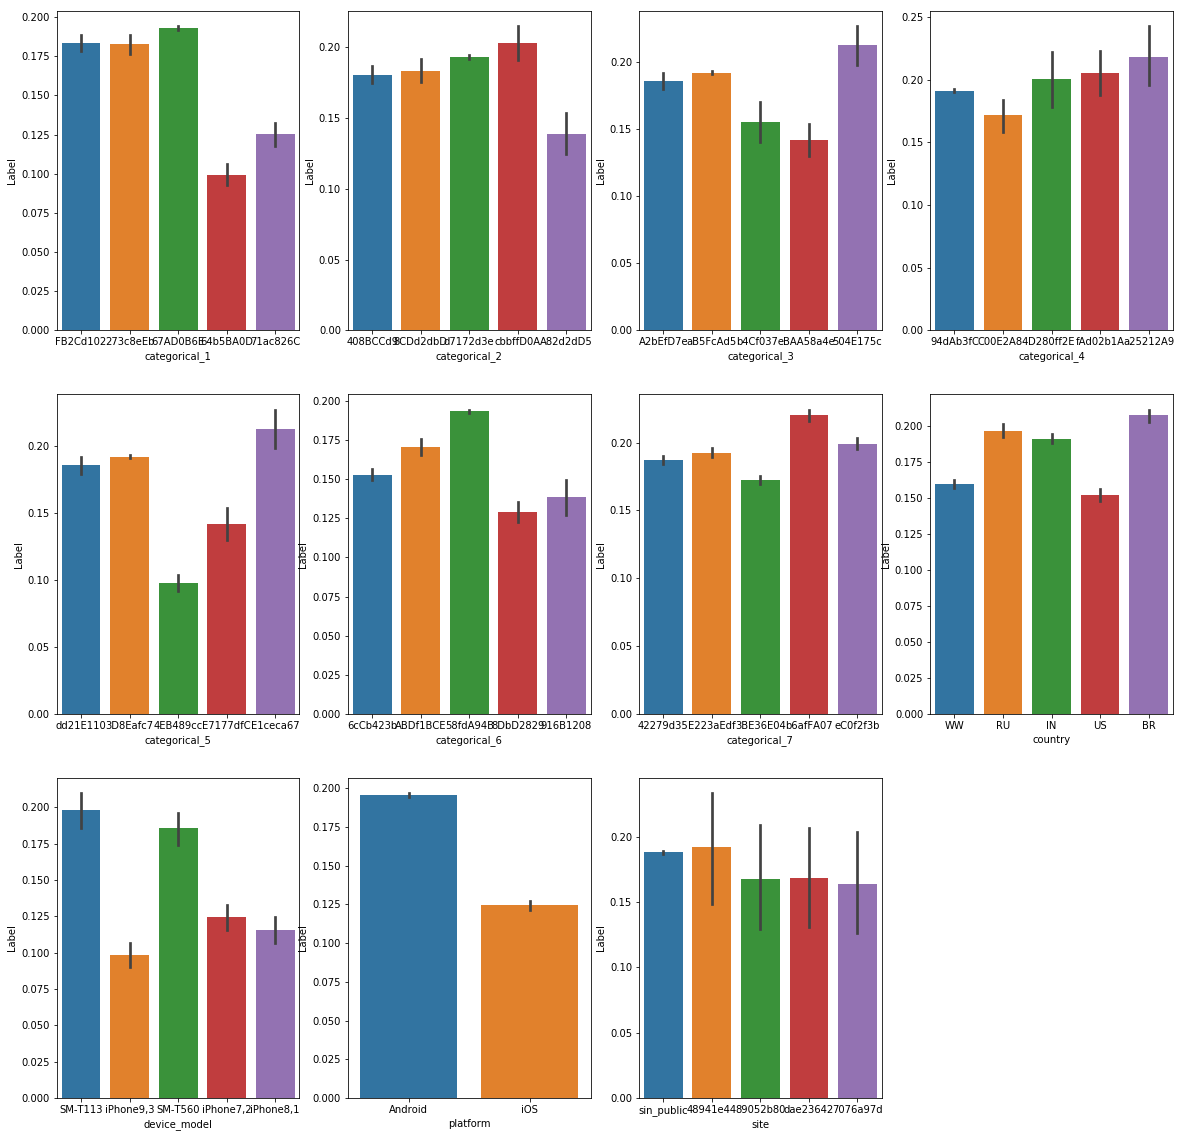

In [9]:
# Comportamiento de las etiquetas Object (string) con respecto a Label

print('5 Etiquetas principales')
print()

f, axes = plt.subplots(3, 4, figsize=(20, 20), sharex=False, sharey=False)
a = 0
b = 0
control = 0

for i in lista_columnas_object:
    print(i)
    c = df.groupby(i).user_id.count().sort_values(ascending=False)
    c_prop = c / c.sum()
    
    c0 = df[df['Label'] == 0].groupby(i).user_id.count().sort_values(ascending=False)
    c0_prop = c0 / c0.sum()
    
    c1 = df[df['Label'] == 1].groupby(i).user_id.count().sort_values(ascending=False)
    c1_prop = c1 / c1.sum()
    
    r = c_prop
    r0 = c0_prop
    r1 = c1_prop
    
    r_total = pd.concat([r, r0, r1], axis=1, sort = True)
    r_total.columns = ['Todos', 'Label 0', 'Label 1']
    r_total = r_total.sort_values(by=['Todos'], ascending=False)
    
    print(r_total.head(5))
    print('Cantidad de etiquetas distintas: '+str(len(c_prop)))
    sns.barplot(data=df[df[i].isin(r_total.head(5).index)], x=i, y='Label')
    print()
    
    sns.barplot(data=df[df[i].isin(r_total.head(5).index)], x=i, y='Label', ax=axes[a, b])
    control +=1
    b +=1 
    if (control== 4) or (control== 8):
        a +=1
    if (b==4):
        b = 0
    
f.delaxes(axes[2][3])

<b>CONCLUSION</b>

Se determina que para las columnas categorical_7, country, site se completaran con una etiqueta nueva por la cantidad de nulos que tienen y las naturaleza de las variables.
Con respecto a device_model, se determina eliminar los registros que tienen este valor null porque son muy pocos.

Ademas, una alternativa puede ser crear una gran etiqueta para equellos que tienen una etiqueta unica

<h3>Tratamiento de valores nulos - Numericas </h3>

In [11]:
# VARIABLES NUMERICAS CON VALORES NULOS

# Age  
# ChangeArena_sum_dsi3
# OpenChest_sum_dsi2
# StartBattle_sum_dsi1

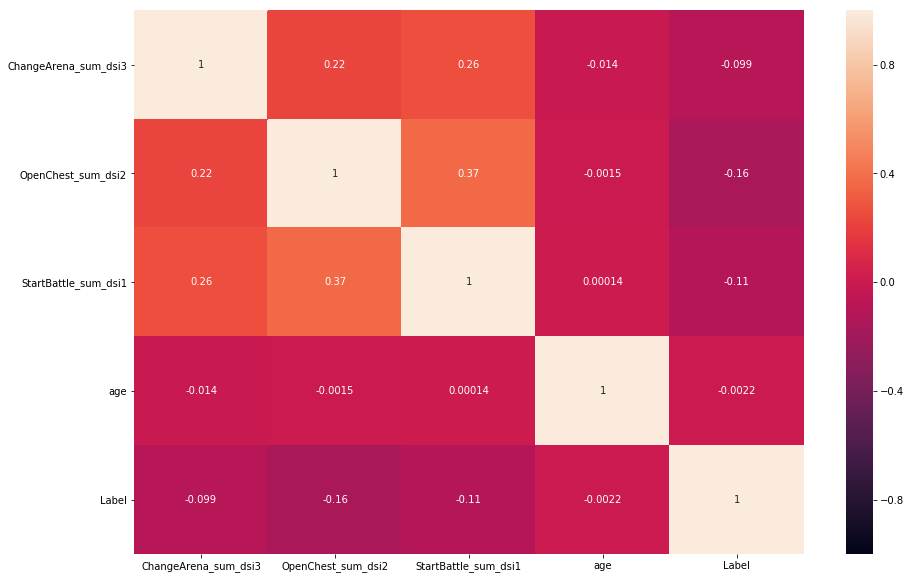

In [12]:
# calculate the correlation matrix of numerical missing values
corr = df[['ChangeArena_sum_dsi3','OpenChest_sum_dsi2','StartBattle_sum_dsi1','age','Label']]

# plot the heatmap
plt.subplots(figsize=(15,10))
sns.heatmap(corr.corr(), 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1,
        annot=True)

# Age es la que menos correlacion lineal presenta con la variable objetivo

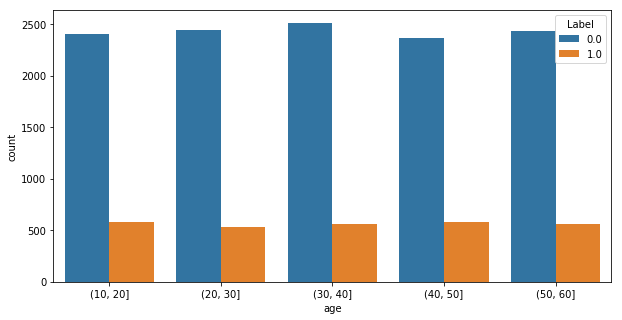

In [13]:
# Ya no se veia una correlacion lineal entre Label y Age. 
# Veamos como se da el comportamiento entre Label por intervalo de edades.

mybins = range(int(df[df.age.notnull()].age.min()), int(df[df.age.notnull()].age.max()), 10)
s = pd.cut(df[df.age.notnull()].age, bins=mybins).dropna()
s = pd.merge(s, df.Label, left_index=True, right_index=True, how='left')

plt.subplots(figsize=(10,5))
sns.countplot(x="age", hue="Label", data=s)

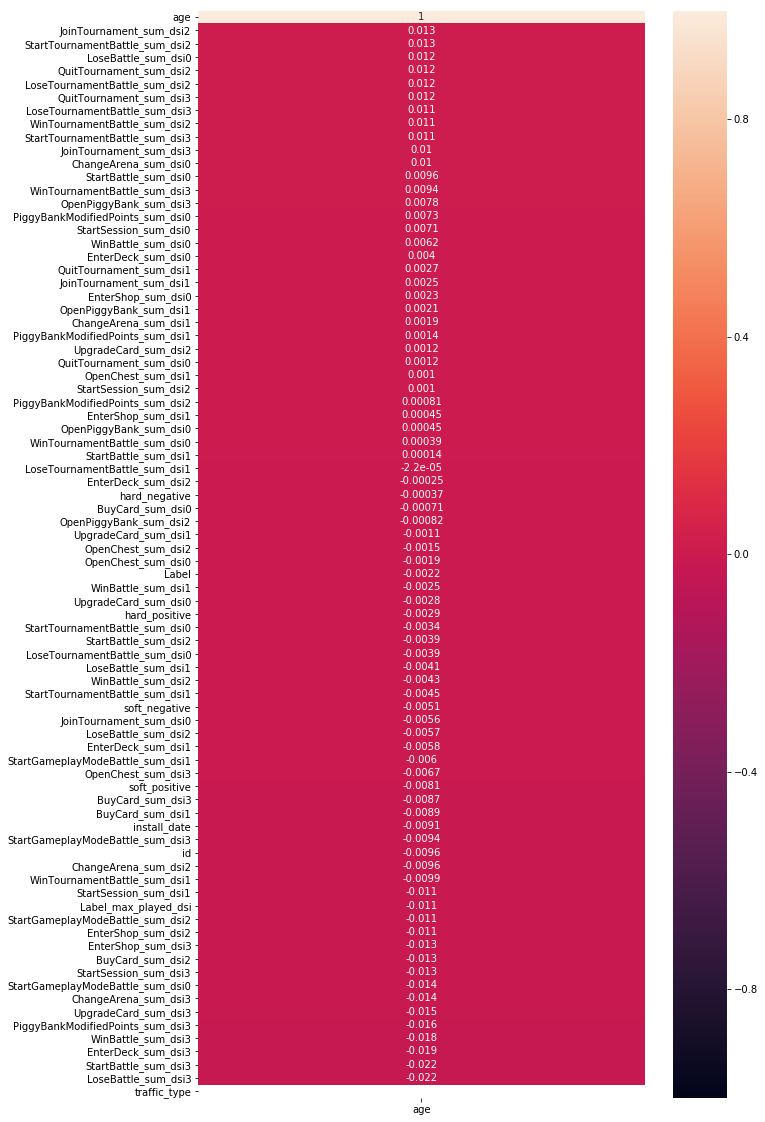

In [5]:
# age

# calculate the correlation matrix of numerical missing values
corr = df[lista_columnas_num]
sub_corr = corr.corr()
sub_corr = sub_corr.sort_values(by=['age'],ascending=False)

# plot the heatmap
plt.subplots(figsize=(10,20))
sns.heatmap(sub_corr[['age']], 
        xticklabels=['age'],
        vmin=-1, vmax=1,
        annot=True)


Decidimos eliminar la columna "Age" ya que parece no aportar mucha informacion para explicar el label en cuestion y tiene muchos valores nulos. Ademas, no correlaciona con ninguan otra variable numerica por lo que es imposible imputar las un valor cercano al real mediante alguna correlacion.

Obervemos el comportamiento de las variables numericas terminadas en  _sum_dsiX (sin tener en cuenta los valores nulos).
La hipotesis para completarlos con el promedio de ese mismo campo, tomando unicamente los valores de alguna otra variable que correlacione con la anterior.
Por ejemplo, para cada row con OpenChest_sum_dsi2 null, si correlaciona con StartBattle_sum_dsi2, entonces se toma la media de OpenChest_sum_dsi2 donde los valores de StartBattle_sum_dsi2 sean similares.

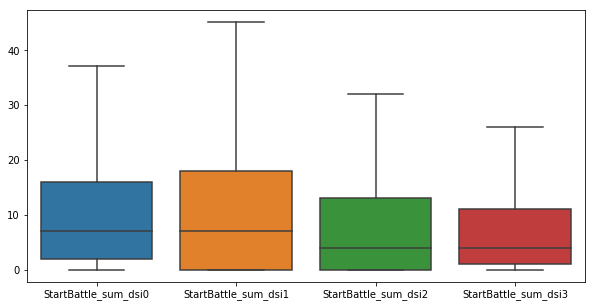

In [8]:
# Nulls in StartBattle_sum_dsi1
plt.subplots(figsize=(10,5))
sns.boxplot(data=df[["StartBattle_sum_dsi0","StartBattle_sum_dsi1","StartBattle_sum_dsi2","StartBattle_sum_dsi3"]], orient="v", showfliers = False)

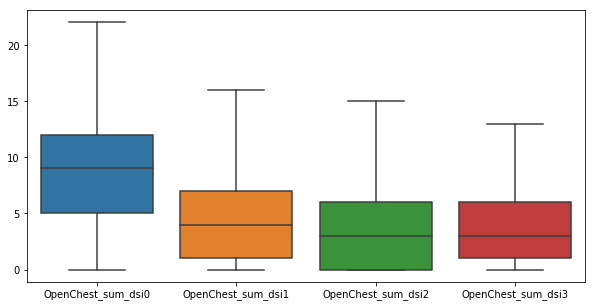

In [9]:
# Nulls in OpenChest_sum_dsi2
plt.subplots(figsize=(10,5))
sns.boxplot(data=df[["OpenChest_sum_dsi0","OpenChest_sum_dsi1","OpenChest_sum_dsi2","OpenChest_sum_dsi3"]], orient="v", showfliers = False)

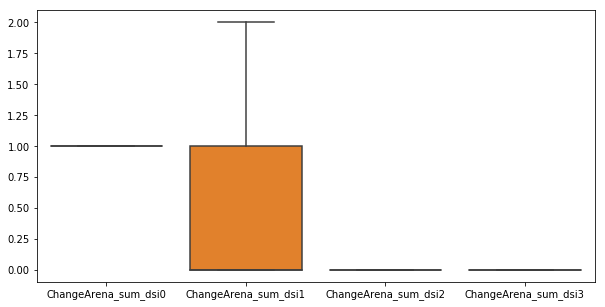

In [10]:
# Nulls in ChangeArena_sum_dsi3
plt.subplots(figsize=(10,5))
sns.boxplot(data=df[["ChangeArena_sum_dsi0","ChangeArena_sum_dsi1","ChangeArena_sum_dsi2","ChangeArena_sum_dsi3"]], orient="v", showfliers = False)

In [123]:
sum_dsiX_columns = [col for col in df.columns if 'sum_dsi' in col]

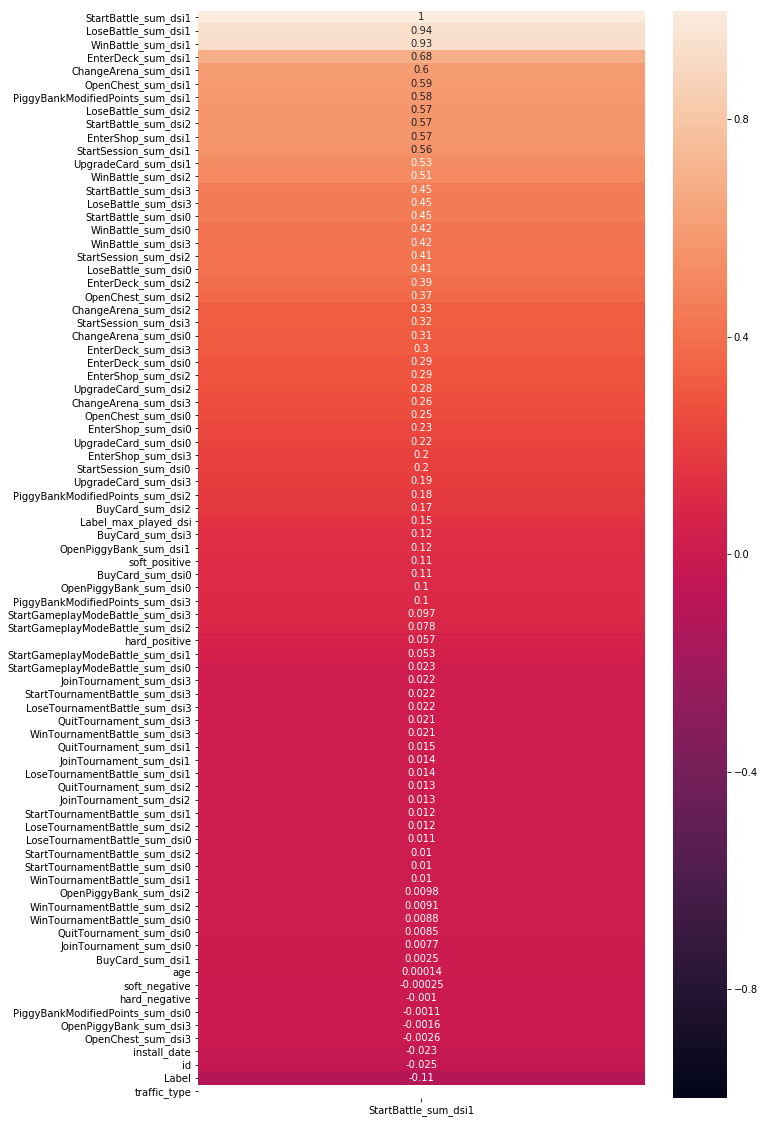

In [135]:
# StartBattle_sum_dsi1

# calculate the correlation matrix of numerical missing values
corr = df[sum_dsiX_columns]
sub_corr = corr.corr()
sub_corr = sub_corr.sort_values(by=['StartBattle_sum_dsi1'],ascending=False)

# plot the heatmap
plt.subplots(figsize=(10,20))
sns.heatmap(sub_corr[['StartBattle_sum_dsi1']], 
        xticklabels=['StartBattle_sum_dsi1'],
        vmin=-1, vmax=1,
        annot=True)


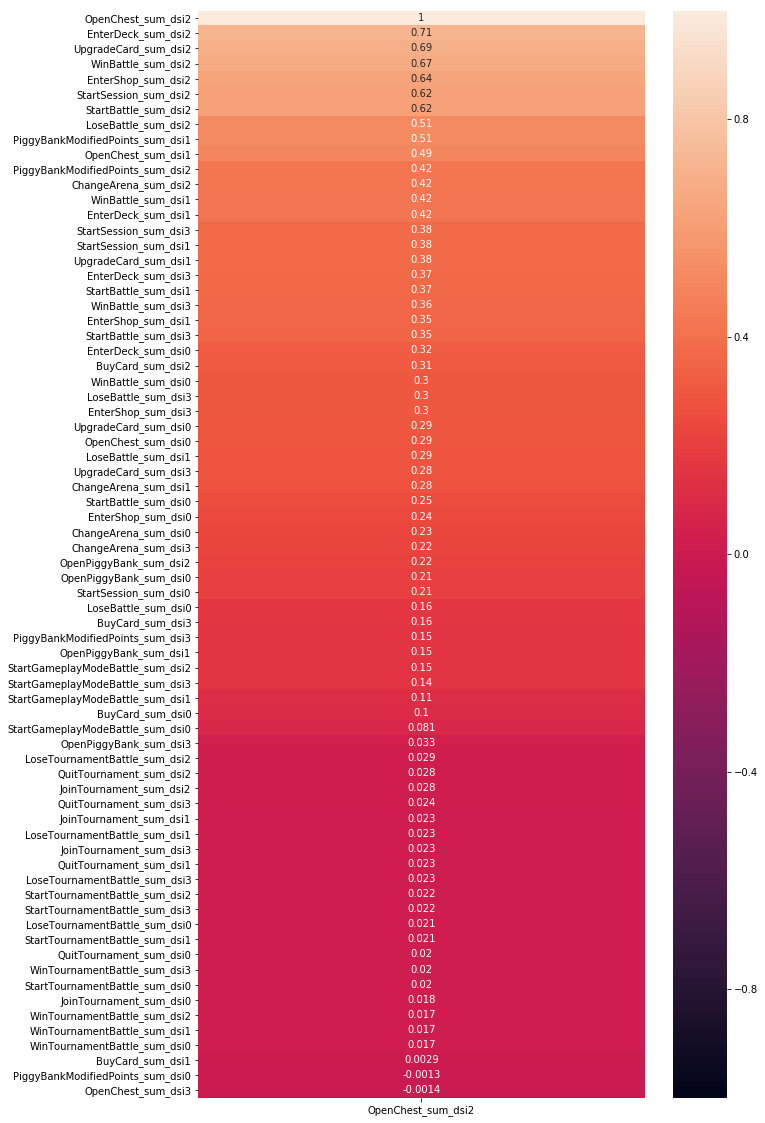

In [133]:
# OpenChest_sum_dsi2
# calculate the correlation matrix of numerical missing values
corr = df[sum_dsiX_columns]
sub_corr = corr.corr()
sub_corr = sub_corr.sort_values(by=['OpenChest_sum_dsi2'],ascending=False)

# plot the heatmap
plt.subplots(figsize=(10,20))
sns.heatmap(sub_corr[['OpenChest_sum_dsi2']], 
        xticklabels=['OpenChest_sum_dsi2'],
        vmin=-1, vmax=1,
        annot=True)

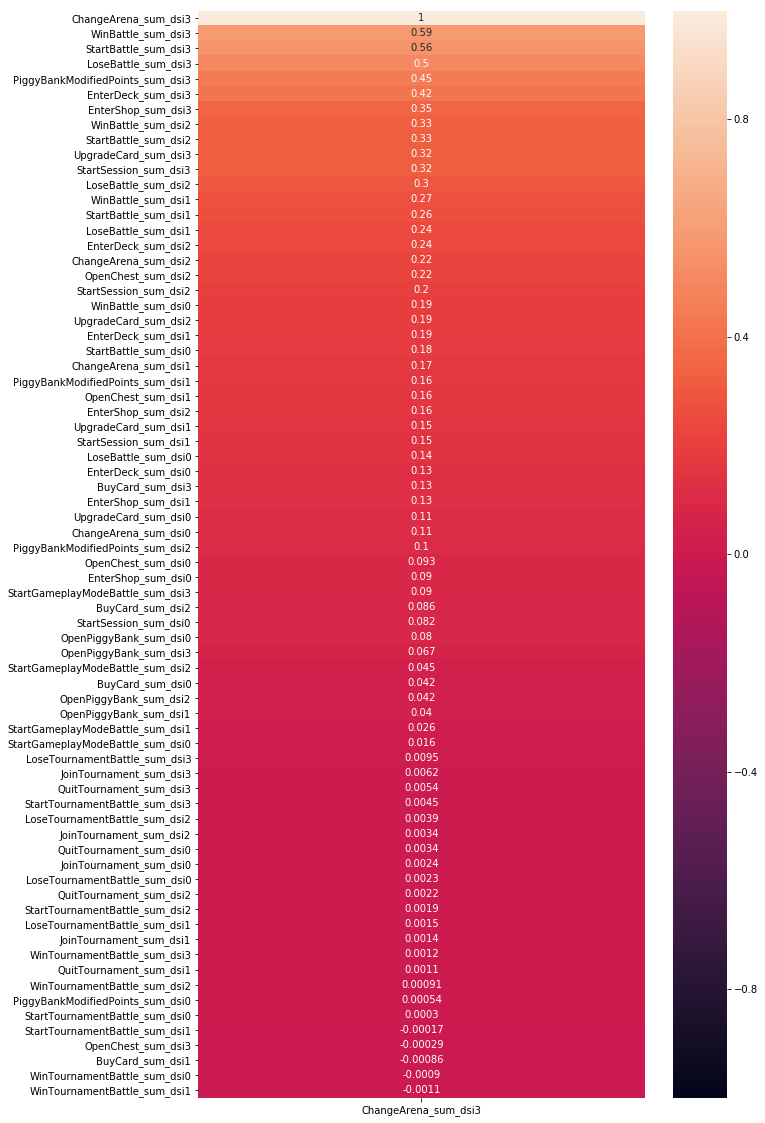

In [134]:
# ChangeArena_sum_dsi3
# calculate the correlation matrix of numerical missing values
corr = df[sum_dsiX_columns]
sub_corr = corr.corr()
sub_corr = sub_corr.sort_values(by=['ChangeArena_sum_dsi3'],ascending=False)

# plot the heatmap
plt.subplots(figsize=(10,20))
sns.heatmap(sub_corr[['ChangeArena_sum_dsi3']], 
        xticklabels=['ChangeArena_sum_dsi3'],
        vmin=-1, vmax=1,
        annot=True) 


Para los primeros dos casos encontramos que "StartBattle_sum_dsi1" y "OpenChest_sum_dsi2" tienen una alta correlacion con "LoseBattle_sum_dsi1" y "EnterDeck_sum_dsi2" respectivamente. 
<br>
<br>
Esto tiene sentido, ya que comenzar una batalla con respecto a la cantidad de batallas perdidas puede presentar una cierta correlacion positiva (94% para este caso). La cantidad de cofres abiertos con respecto a entrar a la pagina donde aparecen sus cartas (y desde donde se abren los cofres) tambien tiene mucho sentido su correlacion lineal de 71% positiva.
<br>
<br>
En el tercer caso para "ChangeArena_sum_dsi3", la mayor correlacion lineal se presenta con "WinBattle_sum_dsi1" en un 60% positiva. Si bien tiene una alta correlacion consideramos que no es suficiente y por lo tanto a esta columna le imputaremos el valor 0 a los valores nul. Esto es porque la media de esta columna es 0, donde el 86% de los registros son 0.

<b>CONCLUSION</b>
<br>
<br>
Eliminaremos la variable "Age" porque no explica o aporta informacion a Label, por lo menos de manera lineal y tiene muchos outliers.
<br>
<br>
Imputaremos la media de los valores mas similares con respecto a las correlaciones lineales mas altas para "StartBattle_sum_dsi1" y "OpenChest_sum_dsi2".
<br>
<br>
Imputaremos 0 para "ChangeArena_sum_dsi3", ya que llegamos a la conclusion que es el mejor valor en terminos de simplificacion y representacion de la realidad.


<h3>Funcion tratamiento de valores nulos y outliers (categoricos y numericos)</h3>

In [4]:
# Cleaner del dataset (completa nulls y trata outliers numericos y categoricos)
cleaner = cl.Cleaner()
df = cleaner.clean_all(df)

<h2>Primer modelo</h2>

In [9]:
df.drop(lista_columnas_object, axis=1, inplace = True)

In [10]:
def evaluate_roc(model, test_features, test_labels): # Function to evaluate the AUC ROC
    predictions = model.predict(test_features) # Prediction of the model
    roc = roc_auc_score(test_labels, predictions) # Calculate the metrics comparing real vs predict
    return roc

def evaluate_confMat(model, features, labels): # Function to evaluate the Confusion Matrix
    predictions = model.predict(features) # Prediction of the model
    confMat = confusion_matrix(labels, predictions) # Calculate the metrics comparing real vs predict
    return confMat

In [60]:
features = df.loc[:, df.columns != 'Label']
labels = df.loc[:, df.columns == 'Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

tree_clf = DecisionTreeClassifier()

"""
tree_clf = DecisionTreeClassifier(max_depth=35, 
                                  min_samples_leaf=8, 
                                  min_samples_split=13,
                                  max_leaf_nodes = 20000,
                                  random_state=42)
"""
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [61]:
print('Train results:')
print(evaluate_roc(tree_clf, X_train, y_train))
print(evaluate_confMat(tree_clf, X_train, y_train))
print()
print('Test results:')
print(evaluate_roc(tree_clf, X_test, y_test))
print(evaluate_confMat(tree_clf, X_test, y_test))

0.9993052662218405
[[312280     13]
 [    97  71870]]
0.5557470073004296
[[109101  24525]
 [ 21895   9163]]


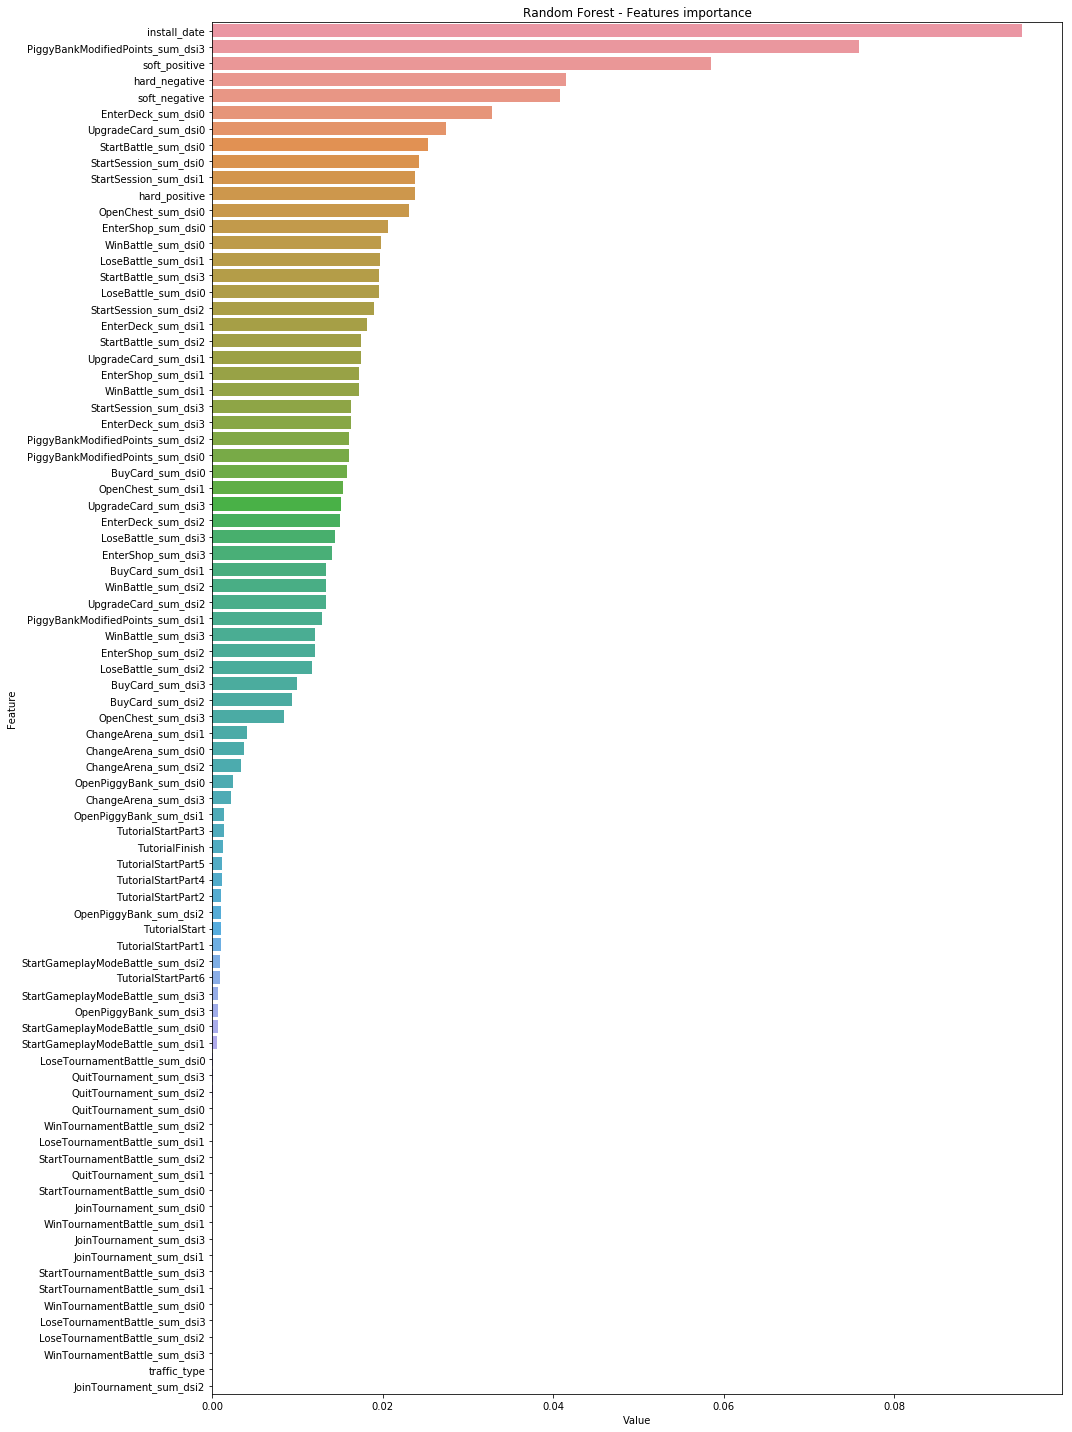

In [64]:
# SKlearn models have a function that give as the feature importance.
feature_imp = pd.DataFrame(sorted(zip(tree_clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

#Now we plot in a barplot the feature importance order by "value" in decending way.
plt.figure(figsize=(15, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest - Features importance')
plt.tight_layout()
plt.show()